# Dynap-SE

Dynap-SE board consists of 4 chips, each having 4 cores inside. Each core harbors 64 Adaptive Exponential Integrate-and-Fire (AdExpIF) neurons, each with 64 fan-in. That means each AdExpIF neuron has a potential of 64 synapses to receive incoming connections of its presynaptic neurons. There are 4 types of synapses: AMPA, NMDA, GABA_A, and GABA_B.

Each core holds a `parameter group` to store the neuronal and synaptic parameters for its 64 neurons and their incoming synapses. The neurons in the same core share the same parameter values, including time constants, refractory periods, and weights. Therefore, different connection strengths between neurons can only be achieved by setting the same connection multiple times.

For spike input, 1024 spike generators, or virtual neurons, are available implemented on the FPGA. Each of the spike generators can be used as a Poisson spike generator or a normal FPGA spike generator. The overview of the architecture is summarized in figure below.

![architecture](images/dynapse.png)

The connectivity and information delivery between neurons a two-stage tag-based routing scheme [1] is used. It’s a novel routing methodology to handle the asynchronous address-event traffic. In this tutorial detailed explanation of the routing mechanism is omitted. The simulator can be used by defining a simple weight matrices.

<!-- ![network](./images/network_v2.png) -->

[1] S. Moradi, N. Qiao, F. Stefanini, and G. Indiveri, “A scalable multicore architecture with heterogeneous memory structures for dynamic neuromorphic asynchronous processors (dynaps),” IEEE Transactions on Biomedical Circuits and Systems, vol. 12, no. 1, pp. 106–122, 2018.

In [1]:
import sys
sys.path.append(
    "/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/dynapse1/ctxctl_contrib"
)

import samna.dynapse1 as dyn1

from netgen import Neuron, NetworkGenerator

from rockpool.devices.dynapse.dynapse1_jax import (
    DynapSE1Jax,
)

from rockpool.devices.dynapse.utils import (
    random_spike_train,
    bias_table, 
    time_const_table, 
    gain_table, 
    synapse_table, 
    device_vs_simulation,
)

from rockpool.devices.dynapse.router import (
    Router
)

from rockpool.devices.dynapse.figure import (
    Figure
)

from rockpool.devices.dynapse.simconfig import (
    DynapSE1SimBoard,
    DynapSE1SimCore,
    DynapSE1Layout,
    DynapSE1Capacitance,
    DPIParameters,
    SynapseParameters,
    MembraneParameters,
    AHPParameters,
    NMDAParameters,
    AMPAParameters,
    GABAAParameters,
    GABABParameters,
)

from rockpool.devices.dynapse.biasgen import (
    BiasGen
)

import numpy as np
import jax.numpy as jnp

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/home/ugurc/anaconda3/envs/synsense/lib/python3.8/site-packages/samna
finished bindings
Could not import package: No module named 'iaf_nest'


## Configure the simulator

In [2]:
net_gen = NetworkGenerator()

spikegen_ids = [(0, 0, 50), (0, 0, 59), (0, 0, 78)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

neuron_ids = [
    (1, 0, 20),
    (1, 0, 36),
    (1, 0, 60),
    (3, 0, 107),
    (3, 0, 152),
    (3, 0, 110),
]
neurons = []
for nid in neuron_ids:
    neurons.append(Neuron(nid[0], nid[1], nid[2]))
    

# connect neuron0 to other neurons
net_gen.add_connection(spikegens[0], neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[1], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[3], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[4], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[2], neurons[2], dyn1.Dynapse1SynType.GABA_A)


net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[0], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[1], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(neurons[0], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[3], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[5], dyn1.Dynapse1SynType.AMPA)

net_gen.network

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C1c0n20: [('C0c0s50', 'AMPA'), ('C3c0n152', 'GABA_B'), ('C3c0n152', 'GABA_B')]
C1c0n36: [('C0c0s50', 'AMPA')]
C1c0n60: [('C0c0s50', 'NMDA'), ('C0c0s50', 'NMDA'), ('C0c0s78', 'GABA_A'), ('C1c0n20', 'AMPA'), ('C1c0n36', 'AMPA'), ('C3c0n152', 'AMPA'), ('C3c0n107', 'AMPA'), ('C1c0n60', 'AMPA'), ('C1c0n60', 'NMDA')]
C3c0n107: [('C0c0s59', 'NMDA'), ('C3c0n152', 'AMPA')]
C3c0n152: [('C0c0s59', 'NMDA'), ('C1c0n20', 'AMPA'), ('C3c0n107', 'AMPA')]
C3c0n110: [('C3c0n107', 'AMPA')]

## Requirements

## Custom Config

In [3]:
# layout?
layout = DynapSE1Layout(Von=.5)

print(layout)

DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5)


In [4]:
c = DynapSE1Capacitance()

print(c)

DynapSE1Capacitance(Co=5e-13, mem=3e-12, ref=1.5e-12, pulse=5e-13, gaba_b=2.5e-11, gaba_a=2.45e-11, nmda=2.5e-11, ampa=2.45e-11, ahp=4e-11)


In [5]:
mem = MembraneParameters(tau=.01, f_gain=1, layout=layout, C=c.mem, Cref=c.ref, Cpulse=c.pulse)

print(mem)

MembraneParameters(Itau=1.0638297829831884e-11, Ith=1.0638297829831884e-11, tau=0.01, f_gain=1, C=3e-12, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Cref=1.5e-12, Cpulse=5e-13, tau2=4.432624095763285e-09, Itau2=2.4e-05, Imem=5e-13, Iref=3.7499999850157395e-10, t_ref=0.002, Ipulse=2.4999999900104927e-08, t_pulse=1e-05, Ispkthr=1e-06, Ireset=5e-13, Idc=5e-13, If_nmda=5e-13)


In [6]:
ahp = AHPParameters(C = c.ahp, layout = layout, Iw=0)

print(ahp)

AHPParameters(Itau=2.836879421288502e-11, Ith=1.1347517685154009e-10, tau=0.05, f_gain=4, C=4e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=0, Isyn=1e-10)


In [7]:
nmda = NMDAParameters(C = c.nmda, layout = layout)

print(nmda)

NMDAParameters(Itau=8.865248345314112e-12, Ith=3.546099338125645e-11, tau=0.1, f_gain=4, C=2.5e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=1e-06, Isyn=1e-10)


In [8]:
ampa = AMPAParameters(C = c.ampa, layout = layout)

print(ampa)

AMPAParameters(Itau=8.687942997014725e-11, Ith=3.47517719880589e-10, tau=0.01, f_gain=4, C=2.45e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=1e-06, Isyn=1e-10)


In [9]:
gaba_a = GABAAParameters(C = c.gaba_a, layout = layout)

# Shunt
print(gaba_a)

GABAAParameters(Itau=8.687942997014725e-11, Ith=3.47517719880589e-10, tau=0.01, f_gain=4, C=2.45e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=1e-06, Isyn=1e-10)


In [10]:
gaba_b = GABABParameters(C = c.gaba_b,layout = layout)

print(gaba_b)

GABABParameters(Itau=8.865248345314112e-12, Ith=3.546099338125645e-11, tau=0.1, f_gain=4, C=2.5e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=1e-06, Isyn=1e-10)


In [11]:
simcore1 = DynapSE1SimCore(
    core_key=(1, 0),
    neuron_idx_map={0: 20, 1: 36, 2: 60},
    layout = layout,
    capacitance = c,
    mem = mem,
    gaba_b = gaba_b,
    gaba_a = gaba_a,
    nmda = nmda,
    ampa = ampa,
    ahp = ahp,
)

print(simcore1)

DynapSE1SimCore(size=3, core_key=(1, 0), neuron_idx_map={0: 20, 1: 36, 2: 60}, fpulse_ahp=0.1, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), capacitance=DynapSE1Capacitance(Co=5e-13, mem=3e-12, ref=1.5e-12, pulse=5e-13, gaba_b=2.5e-11, gaba_a=2.45e-11, nmda=2.5e-11, ampa=2.45e-11, ahp=4e-11), mem=MembraneParameters(Itau=1.0638297829831884e-11, Ith=1.0638297829831884e-11, tau=0.01, f_gain=1, C=3e-12, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Cref=1.5e-12, Cpulse=5e-13, tau2=4.432624095763285e-09, Itau2=2.4e-05, Imem=5e-13, Iref=3.7499999850157395e-10, t_ref=0.002, Ipulse=2.4999999900104927e-08, t_pulse=1e-05, Ispkthr=1e-06, Ireset=5e-13, Idc=5e-13, If_nmda=5e-13), gaba_b=GABABParameters(Itau=8.865248345314112e-12, Ith=3.546099338125645e-11, tau=0.1, f_gain=4, C=2.5e-11, layout=DynapSE1Layout(kappa_n=0.75, kappa_p=0.66, Ut=0.025, Io=5e-13, Von=0.5), Iw=1e-06, Isyn=1e-10), gaba_a=GABAAParameters(Itau=8.687942997014725

In [12]:
import dataclasses
import json
class EnhancedJSONEncoder(json.JSONEncoder):
    def default(self, o):
        if dataclasses.is_dataclass(o):
            return dataclasses.asdict(o)
        else:
            return str(o)
        return super().default(o)

print(json.dumps(simcore1, cls=EnhancedJSONEncoder, indent="\t"))

{
	"size": 3,
	"core_key": [
		1,
		0
	],
	"neuron_idx_map": {
		"0": 20,
		"1": 36,
		"2": 60
	},
	"fpulse_ahp": 0.1,
	"layout": {
		"kappa_n": 0.75,
		"kappa_p": 0.66,
		"Ut": 0.025,
		"Io": 5e-13,
		"Von": 0.5
	},
	"capacitance": {
		"Co": 5e-13,
		"mem": "3e-12",
		"ref": "1.5e-12",
		"pulse": "5e-13",
		"gaba_b": "2.5e-11",
		"gaba_a": "2.45e-11",
		"nmda": "2.5e-11",
		"ampa": "2.45e-11",
		"ahp": "4e-11"
	},
	"mem": {
		"Itau": 1.0638297829831884e-11,
		"Ith": 1.0638297829831884e-11,
		"tau": 0.01,
		"f_gain": 1,
		"C": "3e-12",
		"layout": {
			"kappa_n": 0.75,
			"kappa_p": 0.66,
			"Ut": 0.025,
			"Io": 5e-13,
			"Von": 0.5
		},
		"Cref": "1.5e-12",
		"Cpulse": "5e-13",
		"tau2": 4.432624095763285e-09,
		"Itau2": 2.4e-05,
		"Imem": 5e-13,
		"Iref": 3.7499999850157395e-10,
		"t_ref": 0.002,
		"Ipulse": 2.4999999900104927e-08,
		"t_pulse": 1e-05,
		"Ispkthr": 1e-06,
		"Ireset": 5e-13,
		"Idc": 5e-13,
		"If_nmda": 5e-13
	},
	"gaba_b": {
		"Itau": 8.865248345314112e-12,
		"Ith": 

In [13]:
simcore2 = DynapSE1SimCore(
    core_key=(3, 0), neuron_idx_map={3: 107, 4: 110, 5: 152}
)
print(json.dumps(simcore2, cls=EnhancedJSONEncoder, indent="\t"))

{
	"size": 3,
	"core_key": [
		3,
		0
	],
	"neuron_idx_map": {
		"3": 107,
		"4": 110,
		"5": 152
	},
	"fpulse_ahp": 0.1,
	"layout": {
		"kappa_n": 0.75,
		"kappa_p": 0.66,
		"Ut": 0.025,
		"Io": 5e-13,
		"Von": 0.7
	},
	"capacitance": {
		"Co": 5e-13,
		"mem": "3e-12",
		"ref": "1.5e-12",
		"pulse": "5e-13",
		"gaba_b": "2.5e-11",
		"gaba_a": "2.45e-11",
		"nmda": "2.5e-11",
		"ampa": "2.45e-11",
		"ahp": "4e-11"
	},
	"mem": {
		"Itau": 5.319148914915942e-12,
		"Ith": 1.0638297829831884e-11,
		"tau": 0.02,
		"f_gain": 2,
		"C": "3e-12",
		"layout": {
			"kappa_n": 0.75,
			"kappa_p": 0.66,
			"Ut": 0.025,
			"Io": 5e-13,
			"Von": 0.7
		},
		"Cref": "1.5e-12",
		"Cpulse": "5e-13",
		"tau2": 4.432624095763285e-09,
		"Itau2": 2.4e-05,
		"Imem": 5e-13,
		"Iref": 5.249999979022035e-10,
		"t_ref": 0.002,
		"Ipulse": 3.4999999860146895e-08,
		"t_pulse": 1e-05,
		"Ispkthr": 1e-06,
		"Ireset": 5e-13,
		"Idc": 5e-13,
		"If_nmda": 5e-13
	},
	"gaba_b": {
		"Itau": 8.865248345314112e-12,
		"Ith":

In [14]:
cores = [simcore1, simcore2]
simconfig = DynapSE1SimBoard(cores=cores)

## Samna Config
If we only have the device configuration object, the FPGA-to-device input connections can be defined explicitly in multiple ways by providing a direct input weight matrix or a list of virtual connections.

In [15]:
config = net_gen.make_dynapse1_configuration()
modSE = DynapSE1Jax.simulator_from_config(config, sim_config = simconfig)
modSE

TimedModuleWrapper  with shape (3, 6) {
    JaxSequential '_module' with shape (3, 6) {
        DynapSEFPGA '0_DynapSEFPGA' with shape (3, 6)
        DynapSE1Jax '1_DynapSE1Jax' with shape (6, 6)
    }
} with JaxSequential '_module' as module

In [16]:
fpga = modSE._module.__getattribute__('0_DynapSEFPGA')
se1 = modSE._module.__getattribute__('1_DynapSE1Jax')

## Input Spike Train

Generate an input spike train using utility functions provided `rockpool.devices.dynapse.utils.random_spike_train()` or `rockpool.devices.dynapse.utils.custom_spike_train()`

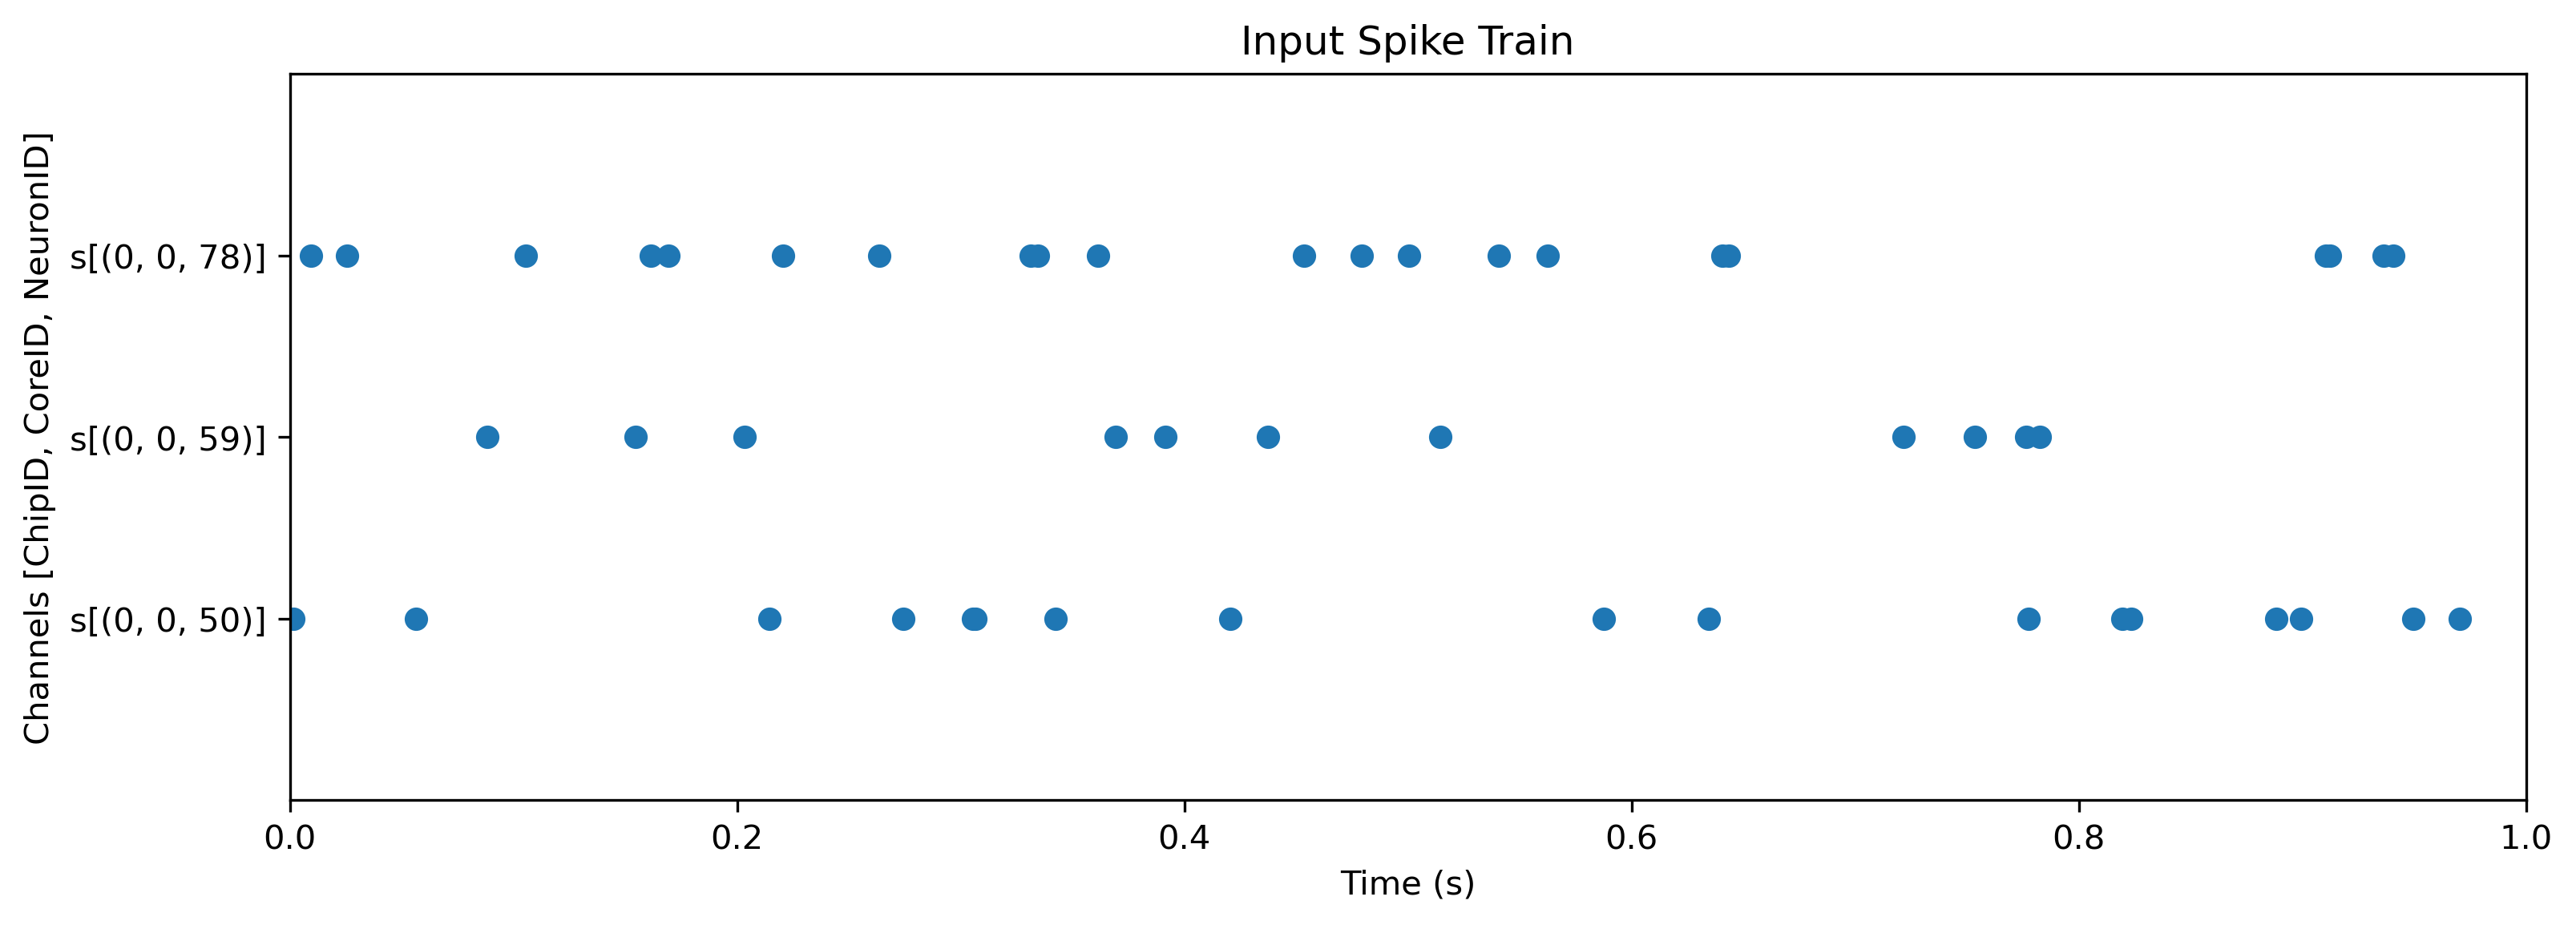

In [17]:
T = 1 # duration in seconds
rate = 20 # firing rate in Hertz

input_ts = random_spike_train(
    duration = T,
    n_channels=len(spikegens),
    rate=rate,
    dt=modSE.dt,
    name='Input Spike Train',
    channel_labels = spikegen_ids
)

input_ts.plot();

## Run the device simulator

Run the model to get output spikes, new_state and the record dictionary. Output spikes is the response of the system, new_state is the resulting state that the network got into, and the record dictionary stores the evolution of the currents. 

In [18]:
out_spikes, new_state, record_dict = modSE(input_ts, record=True)

In [19]:
new_state['1_DynapSE1Jax'].keys()

dict_keys(['spikes', 'Vmem', 'Imem', 'Isyn', 'timer_ref', '_rng_key'])

State dictionary stores 

`spikes` the last time-step output spikes of the neurons *(Nrec,)*

`Vmem`: membrane potentials of the in-device neurons at the last time step *(Nrec,)*

`Imem`: membrane currents of the in-device neurons at the last time step *(Nrec,)*

`Isyn`: synaptic currents of the synapses (AHP, NMDA, AMPA, GABA_A, GABA_B) of the neurons at the last time step *(Nrec,5,)*

`_rng_key`: key to be used in random number generation process

`timer_ref` the refractory timers of the neurons *(Nrec,)*

In [20]:
# Should be initial values
modSE.state()

{'_module': {'0_DynapSEFPGA': {},
  '1_DynapSE1Jax': {'Imem': DeviceArray([5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13], dtype=float32),
   'Isyn': DeviceArray([[1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10],
                [1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10],
                [1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10],
                [1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10],
                [1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10]],            dtype=float32),
   'spikes': DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
   'Vmem': DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
   'timer_ref': DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
   '_rng_key': array([2507456010, 2263290695], dtype=uint32)}}}

In [21]:
assert modSE.state()['_module']['1_DynapSE1Jax'].keys() == new_state['1_DynapSE1Jax'].keys()
assert modSE.state()['_module']['0_DynapSEFPGA'].keys() == new_state['0_DynapSEFPGA'].keys()

In [22]:
print(record_dict.keys())
record_dict['1_DynapSE1Jax'].keys()

dict_keys(['0_DynapSEFPGA', '0_DynapSEFPGA_output', '1_DynapSE1Jax', '1_DynapSE1Jax_output'])


dict_keys(['Vmem', 'Imem', 'Igaba_b', 'Igaba_a', 'Inmda', 'Iampa', 'Iahp'])

Record dictionary stores

`input_data` : rasterized input data provided to the network *(T,Nin,)*

`spikes` : output spikes through time passed *(T,Nrec,)*

`Vmem` : The membrane potentials of the neurons through time  *(T,Nrec,)*

`Imem` : The membrane currents of the neurons through time  *(T,Nrec,)*

`Iahp`, `Inmda`, `Iampa`, `Igaba_a`, `Igaba_b` : Synaptic currents of the neurons through time *(T,Nrec,5)*

In [23]:
se1.parameters().keys()

dict_keys(['w_rec', 'Itau_syn', 'f_gain_syn', 'Iw', 'Itau_mem', 'Itau2_mem', 'f_gain_mem', 'Idc', 'If_nmda'])

The module has the parameters 

`w_rec` : recurrents synapses from real in-device neruons to real in-device neruons *(Nrec, Nrec, 4)*

`Itau_mem` : membrane current of the neurons *(Nrec,)*

`f_gain_mem` : gain parameter for the membrane weight current $ f_{gain} = \dfrac{I_{th}}{I_{\tau}}$ *(Nrec,)*

`Itau_syn` : synaptic leakage currents of 5 synapses (AHP, NMDA, AMPA, GABA_A, GABA_B) *(5,Nrec,)*

`f_gain_syn`: gain parameter for the weight current $ f_{gain} = \dfrac{I_{th}}{I_{\tau}}$ *(5,Nrec,)*

`Iw`: membrane weight current *(Nrec,)*

`Idc` : Constant DC current in Amperes, injected to membrane

`If_nmda` : The NMDA gate current in Amperes setting the NMDA gating voltage. If $V_{mem} > V_{nmda}$ : The $I_{syn_{NMDA}}$ current is added up to the input current, else it cannot

In [24]:
fpga.parameters().keys()

dict_keys(['w_in'])

`w_in` : the input synapses from the virtual FPGA neurons to the real in-device neruons *(Nin, Nrec, 4)*

### DPI 
Assume that $I_w >> I_{\tau}$, and following $I_{syn} >> I_{th}$

$$\tau \dfrac{d}{dt} I_{syn} + I_{syn} = \dfrac{I_w I_{th}}{I_{\tau}}$$

$$I_{syn} (t) = \begin{cases} \dfrac{I_{th} I_{w}}{I_{\tau}}\left( 1 - e^{\frac{-(t-t_i^-)}{\tau}} \right) + I_{syn}^{-} e^{\frac{-(t-t_i^-)}{\tau}} ~~~~~~~~~~~~\text{charge} \\ I_{syn}^{+} \cdot e^{\frac{-(t-t_i^+)}{\tau}} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \text{discharge}\end{cases}$$


### Membrane

$$\left( 1 + \dfrac{I_{th}}{I_{mem}} \right) \tau \dfrac{d}{dt} I_{mem} + I_{mem} \left( 1 + \dfrac{I_{ahp}}{I_{\tau}} \right) = I_{mem_{\infty}} + f(I_{mem})$$

In [25]:
se1.simulation_parameters().keys()

dict_keys(['dt', 'kappa', 'Ut', 'Io', 'f_tau_mem', 'f_tau_syn', 't_pulse', 't_pulse_ahp', 't_ref', 'Ispkthr', 'Ireset', 'f_t_ref', 'f_t_pulse'])

The module has the simulation parameters

`dt` :  The time step for the forward-Euler ODE solver

`kappa` : Mean subthreshold slope factor of the transistors with shape *(Nrec,)*

`Ut` : Thermal voltage in Volts with shape *(Nrec,)*

`Io` : Dark current in Amperes that flows through the transistors even at the idle state

`f_tau_mem` : Tau factor for membrane circuit. $f_{\tau} = \dfrac{U_T}{\kappa \cdot C}$, $f_{\tau} = I_{\tau} \cdot \tau$

`f_tau_syn` : A vector of tau factors in the following order: [AHP, NMDA, AMPA, GABA_A, GABA_B]

`t_pulse` : the width of the pulse in seconds produced by virtue of a spike

`t_pulse_ahp` : reduced pulse width also look at ``t_pulse`` and ``fpulse_ahp``

`t_ref` : refractory period in seconds, limits maximum firing rate

`Ispkthr` : Spiking threshold current in with shape *(Nrec,)*

`Ireset` : Reset current after spike generation with shape *(Nrec,)*

`f_t_ref` : The factor of conversion from refractory period in seconds to refractory period bias current in Amperes

`f_t_pulse` :  The factor of conversion from pulse width in seconds to pulse width bias current in Amperes


In [26]:
se1.tau_mem

DeviceArray([0.01, 0.01, 0.01, 0.02, 0.02, 0.02], dtype=float32)

In [27]:
# se1.tau_mem?
print(se1.IF_TAU1_N(1,0).to_json())

{
    "value0": {
        "paramName": "IF_TAU1_N",
        "coarseValue": 0,
        "fineValue": 181,
        "type": "N"
    }
}


In [28]:
print(se1.IF_TAU1_N(3,0).to_json())

{
    "value0": {
        "paramName": "IF_TAU1_N",
        "coarseValue": 0,
        "fineValue": 90,
        "type": "N"
    }
}


The model is also capable of extracting device bias currents depending on the parameters and simulation parameters used in the model

In [29]:
se1.biases

['IF_AHTAU_N',
 'IF_AHTHR_N',
 'IF_AHW_P',
 'IF_BUF_P',
 'IF_CASC_N',
 'IF_DC_P',
 'IF_NMDA_N',
 'IF_RFR_N',
 'IF_TAU1_N',
 'IF_TAU2_N',
 'IF_THR_N',
 'NPDPIE_TAU_F_P',
 'NPDPIE_TAU_S_P',
 'NPDPIE_THR_F_P',
 'NPDPIE_THR_S_P',
 'NPDPII_TAU_F_P',
 'NPDPII_TAU_S_P',
 'NPDPII_THR_F_P',
 'NPDPII_THR_S_P',
 'PS_WEIGHT_EXC_F_N',
 'PS_WEIGHT_EXC_S_N',
 'PS_WEIGHT_INH_F_N',
 'PS_WEIGHT_INH_S_N',
 'PULSE_PWLK_P',
 'R2R_P']

Let's look at the membrane current change. The dashed lines stands for the spike-threshold current. That is, when membrane current hit the spike-threshold, it means that the module generated and event!

# Visualize the State Change

In [30]:
rd = record_dict["1_DynapSE1Jax"]

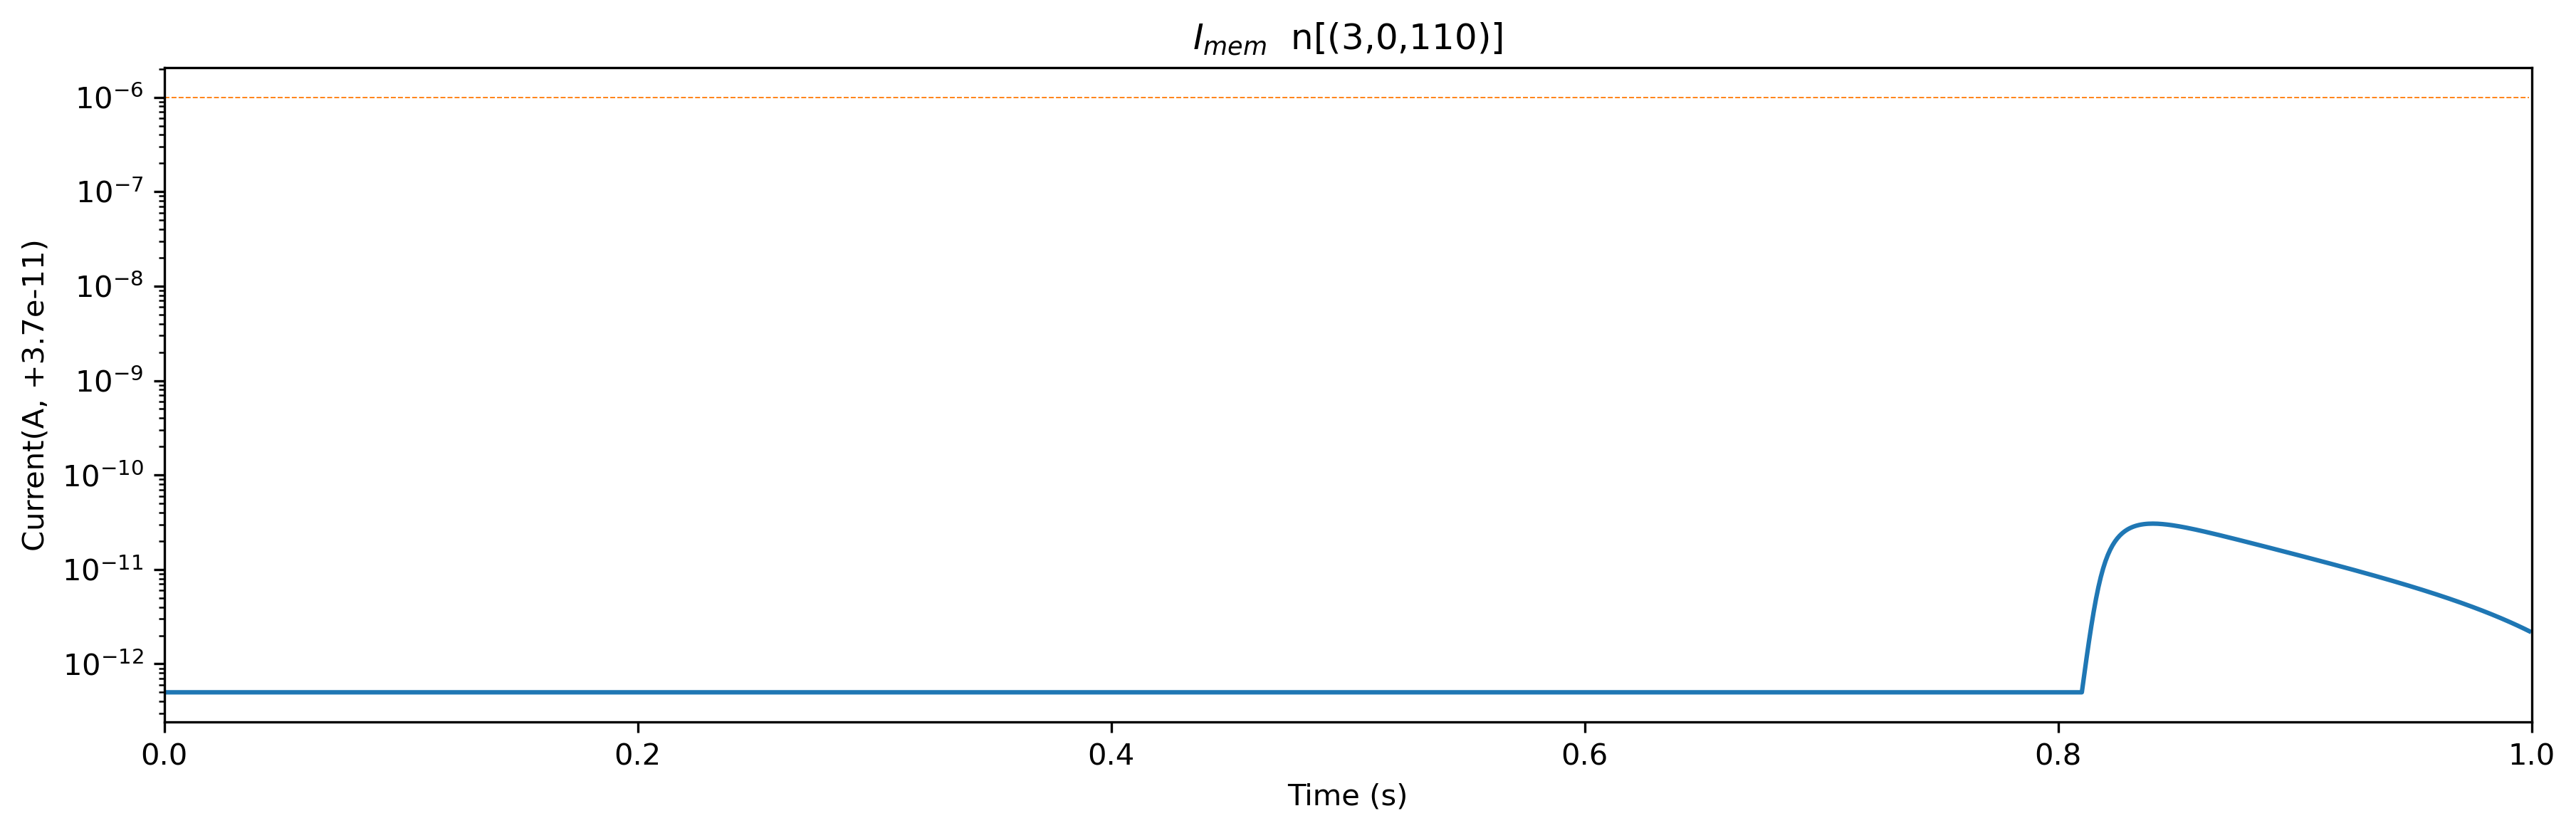

In [31]:
Figure.plot_Ix(rd["Imem"][:,4], se1.Ispkthr[4], name="$I_{mem}$  n[(3,0,110)]");
plt.yscale('log')

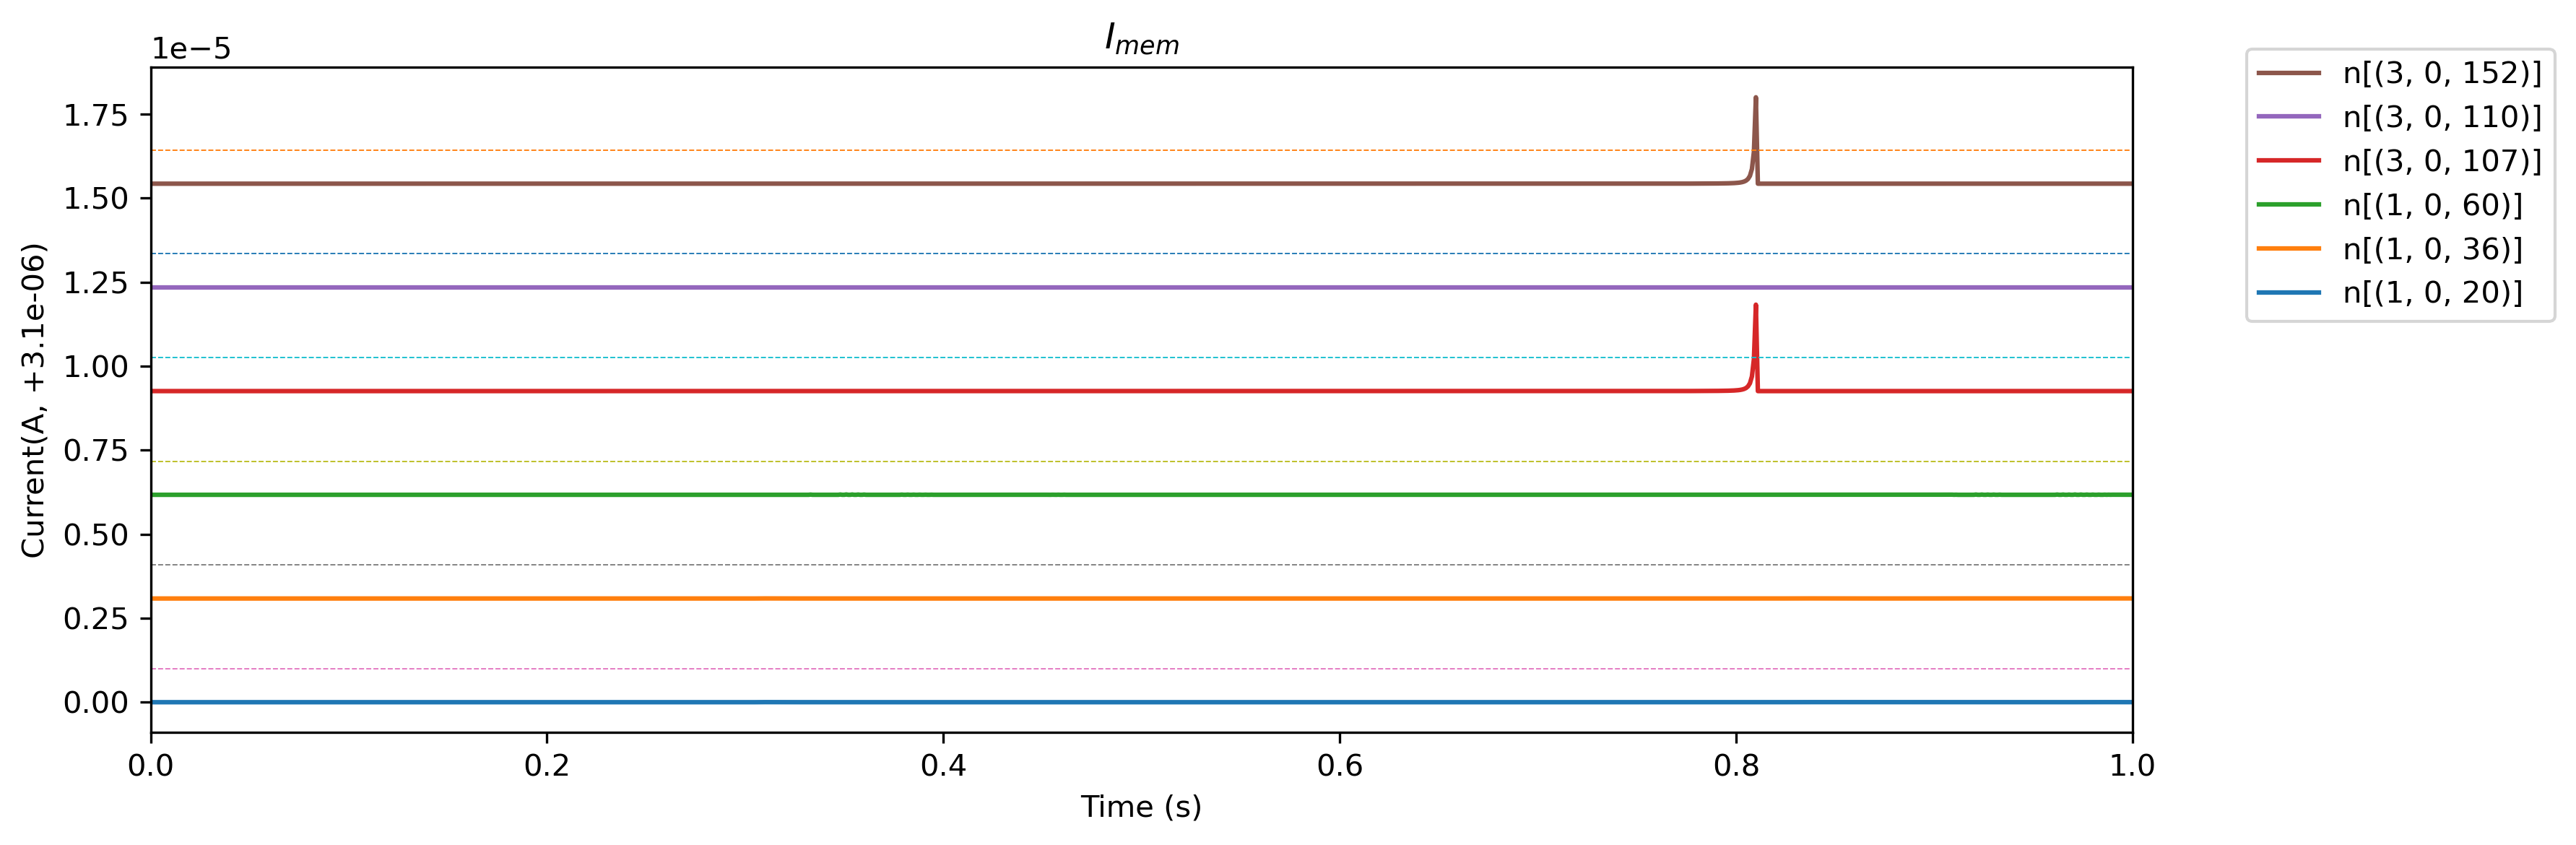

In [32]:
Figure.plot_Ix(rd["Imem"], se1.Ispkthr, name="$I_{mem}$", idx_map=se1.idx_map);

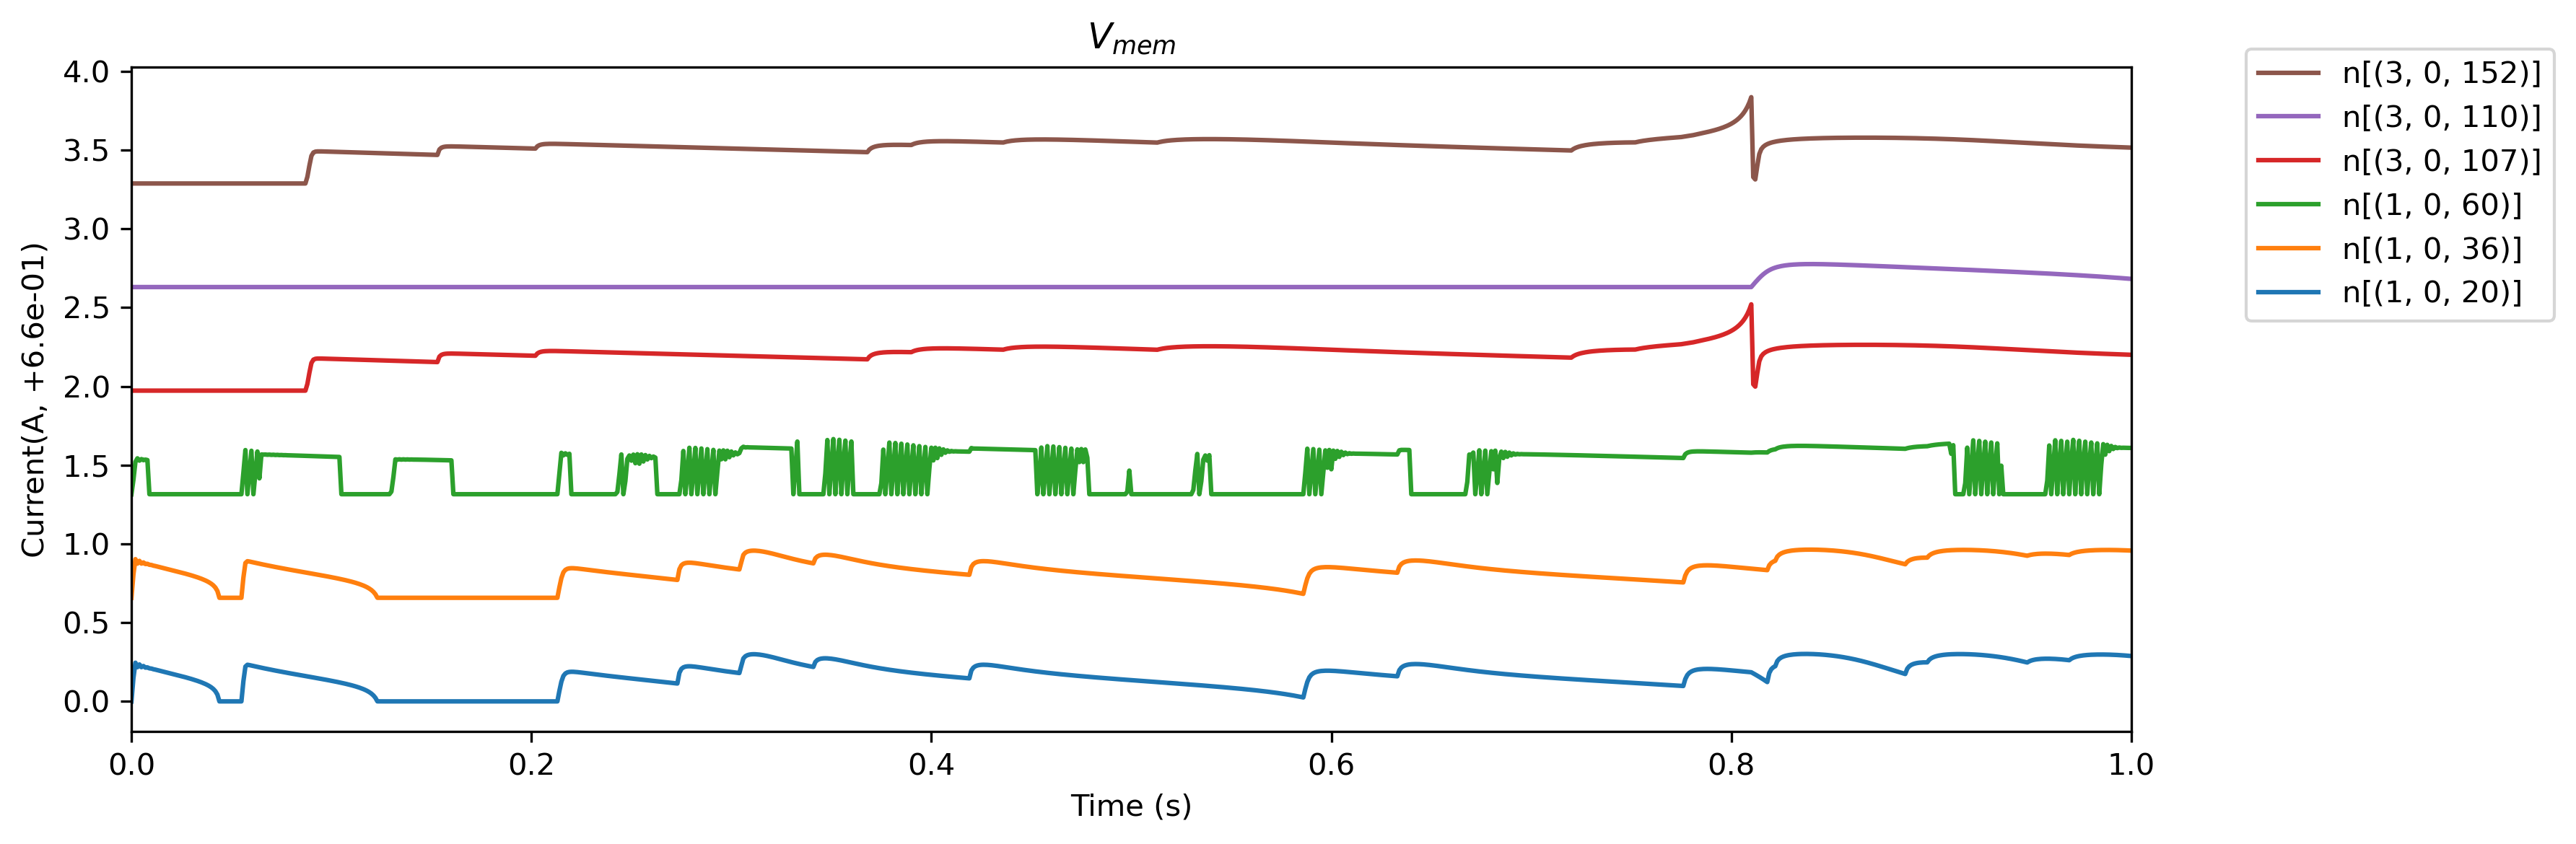

In [33]:
Figure.plot_Ix(rd["Vmem"], name="$V_{mem}$", idx_map=se1.idx_map);

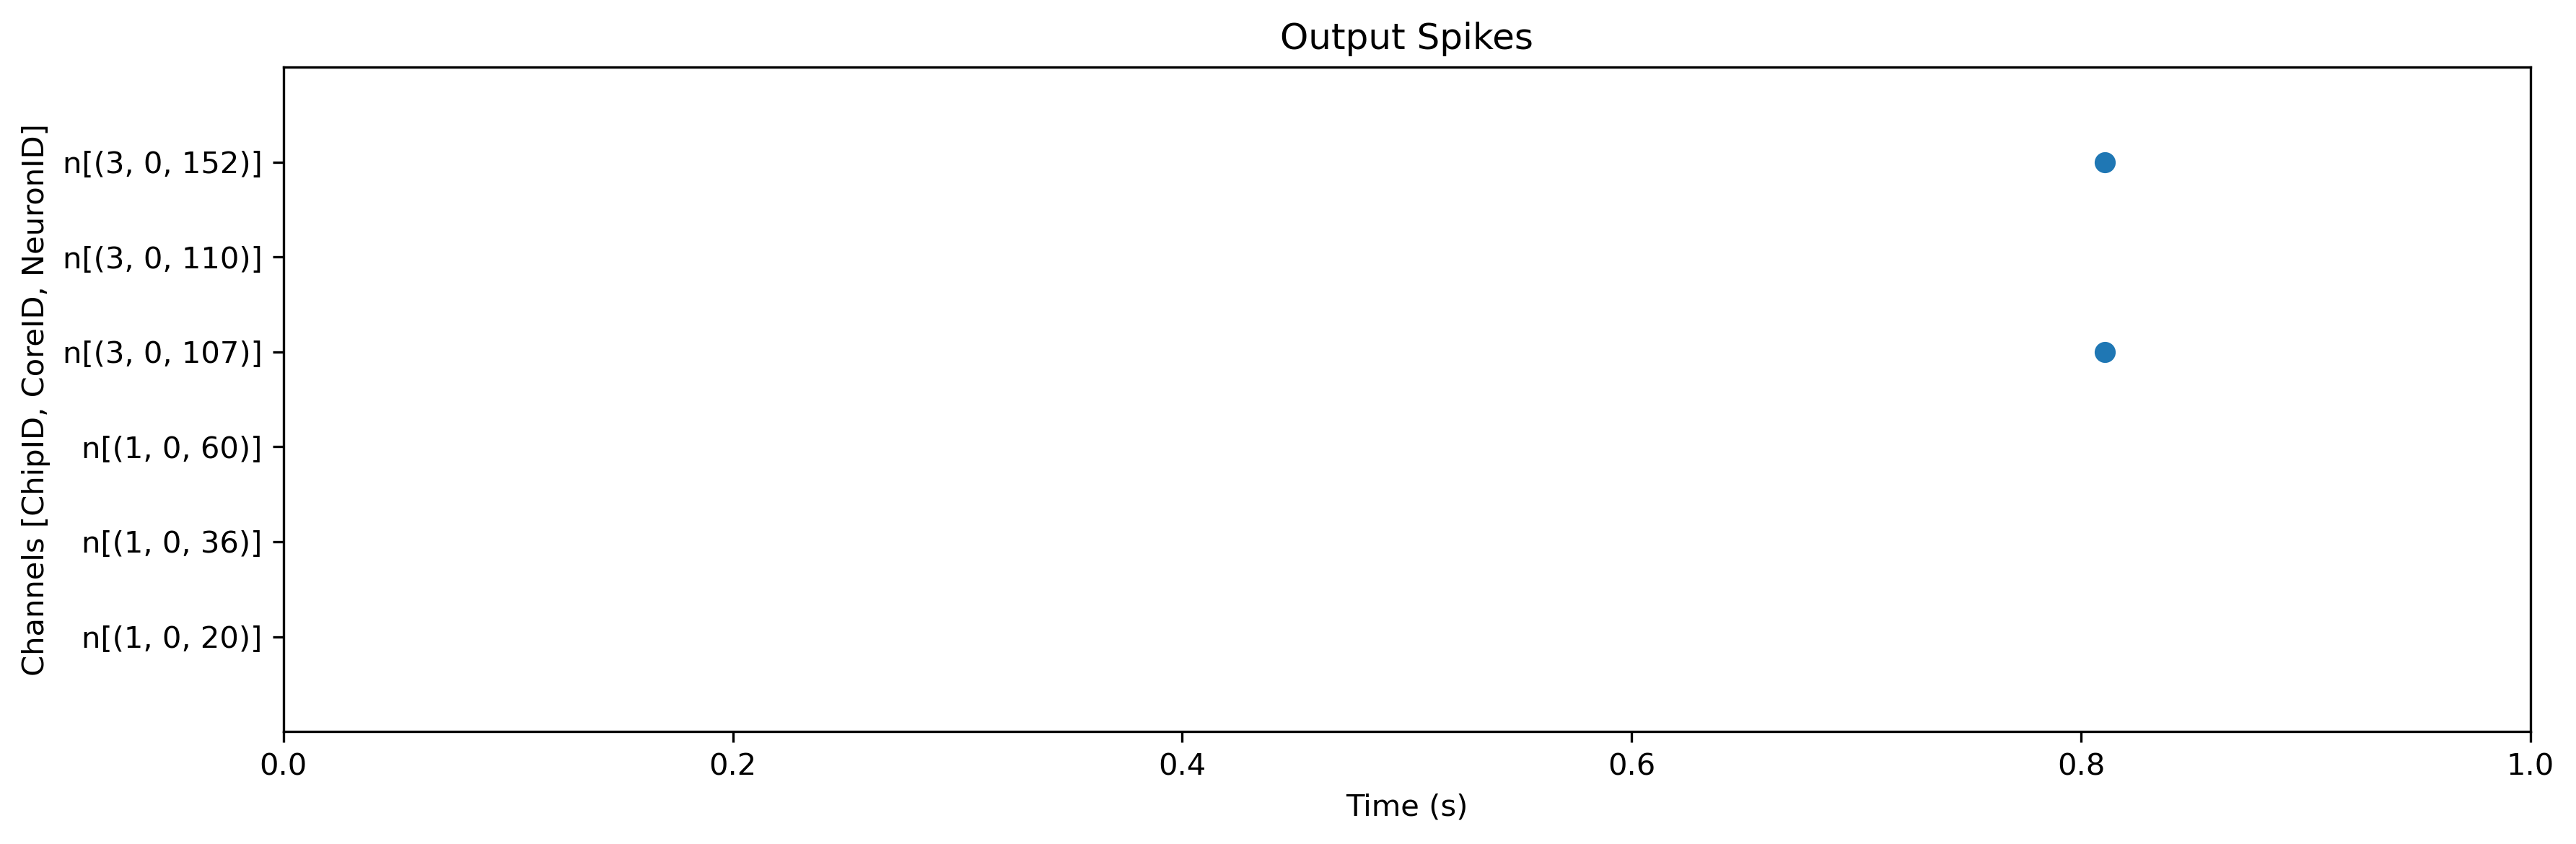

In [34]:
Figure.plot_spikes(record_dict["1_DynapSE1Jax_output"], name="Output Spikes", idx_map=se1.idx_map);

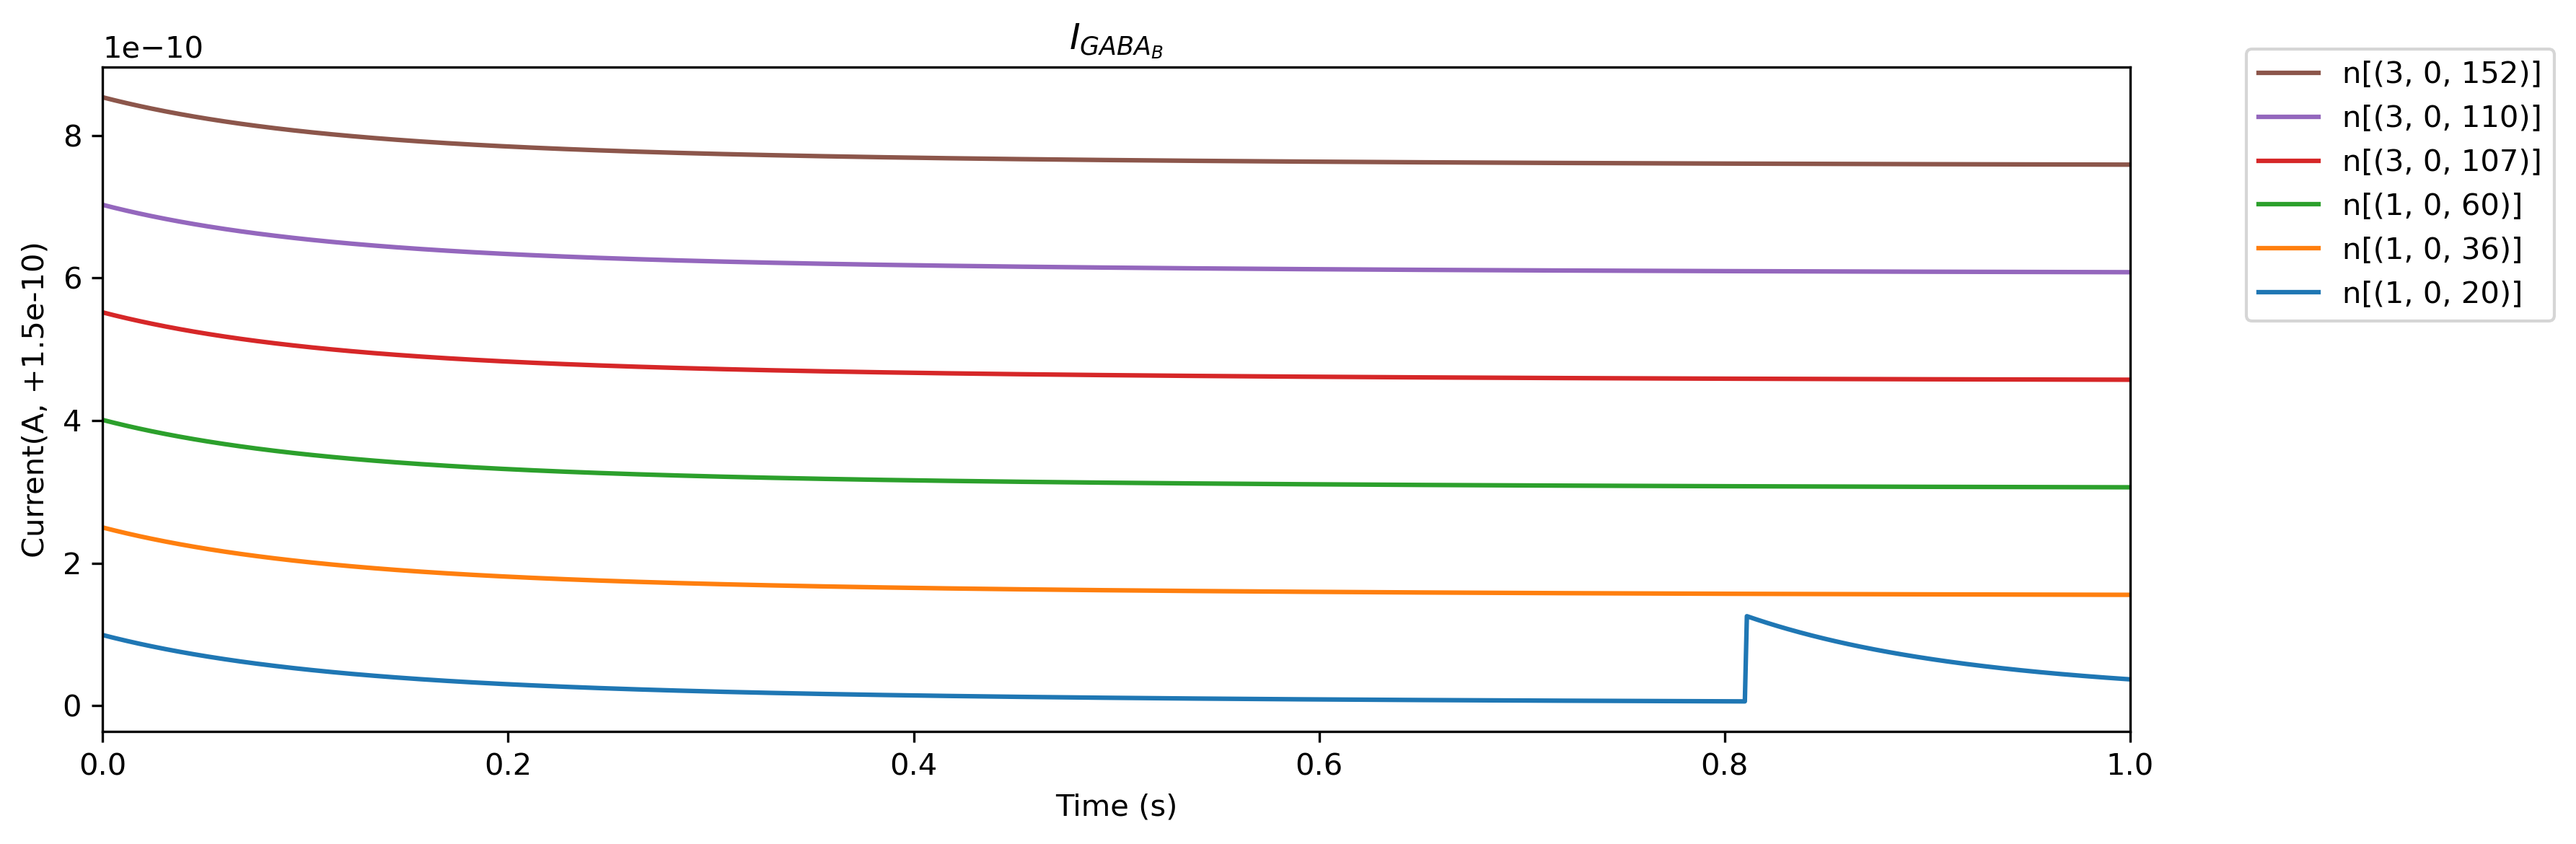

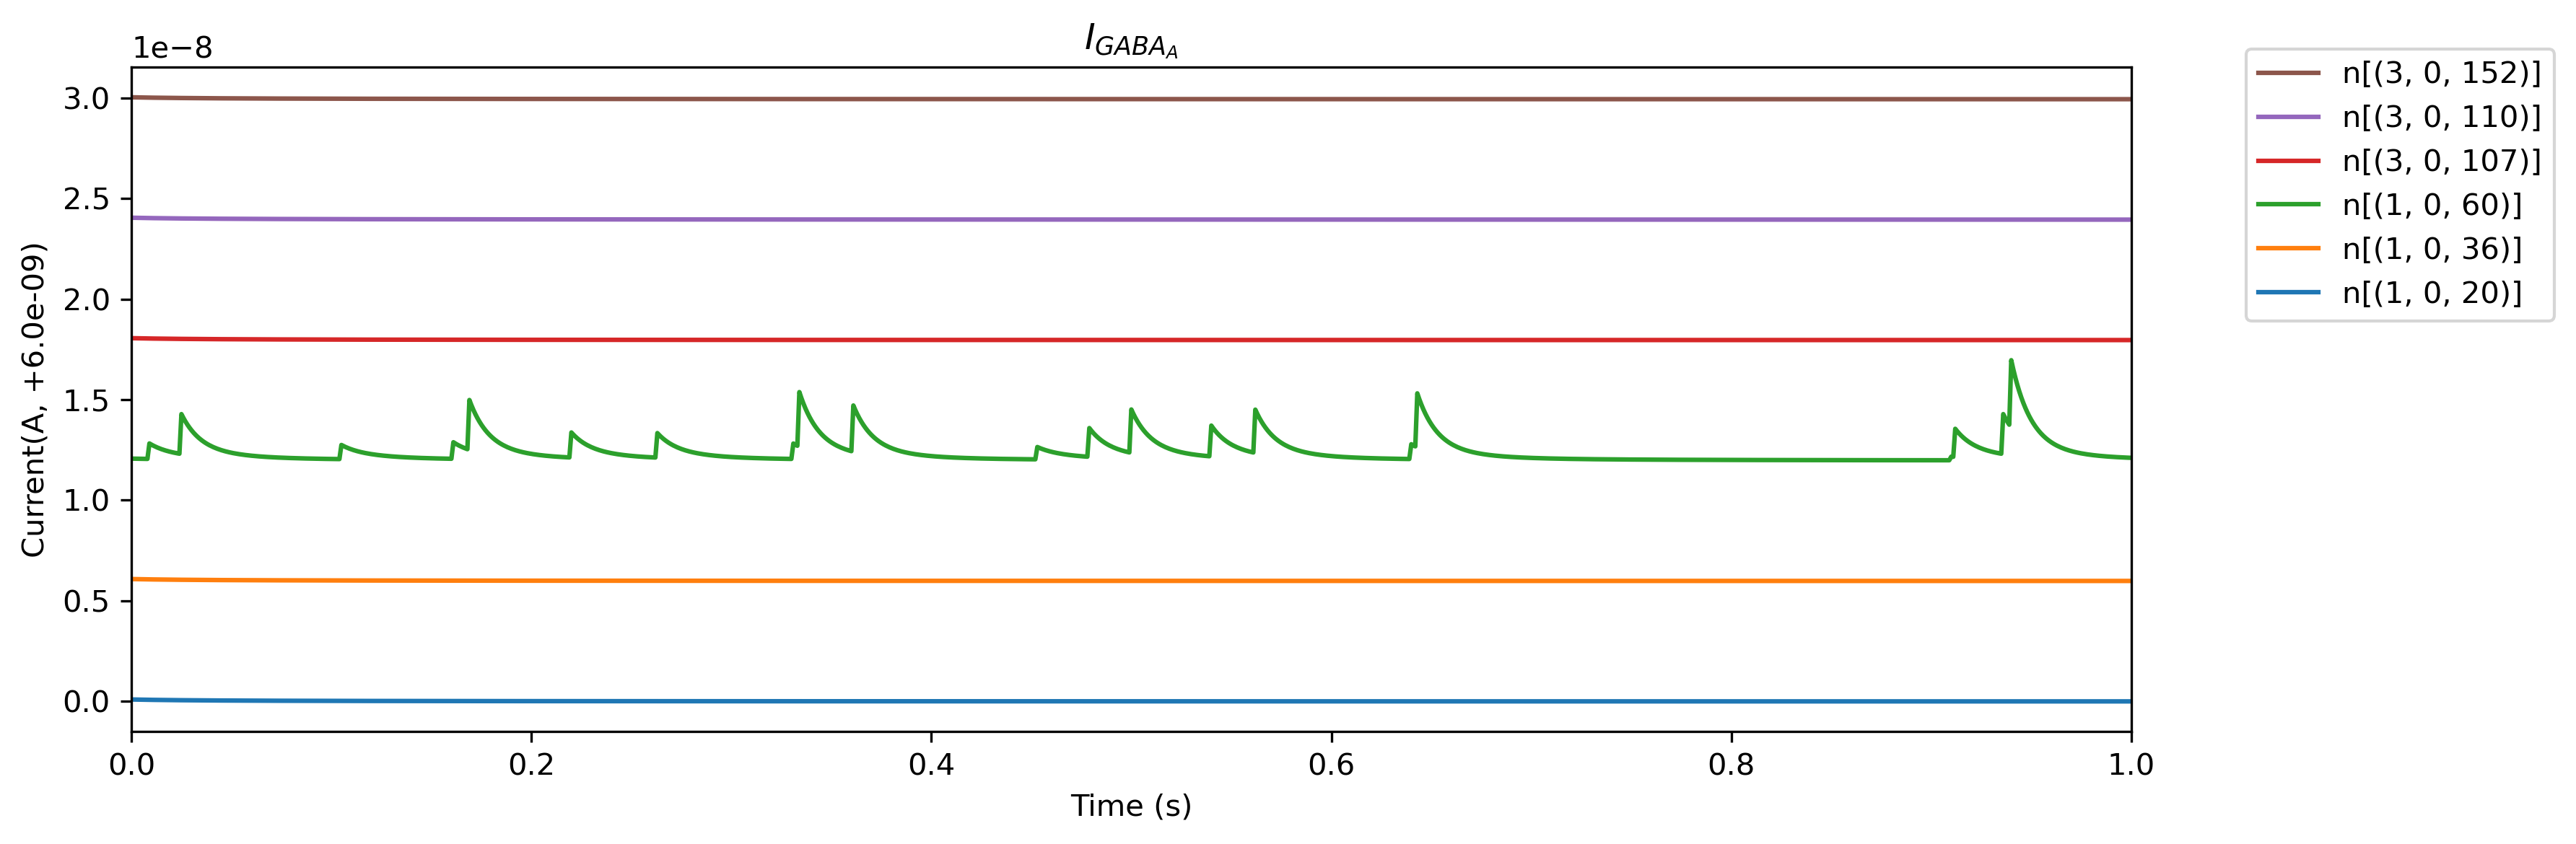

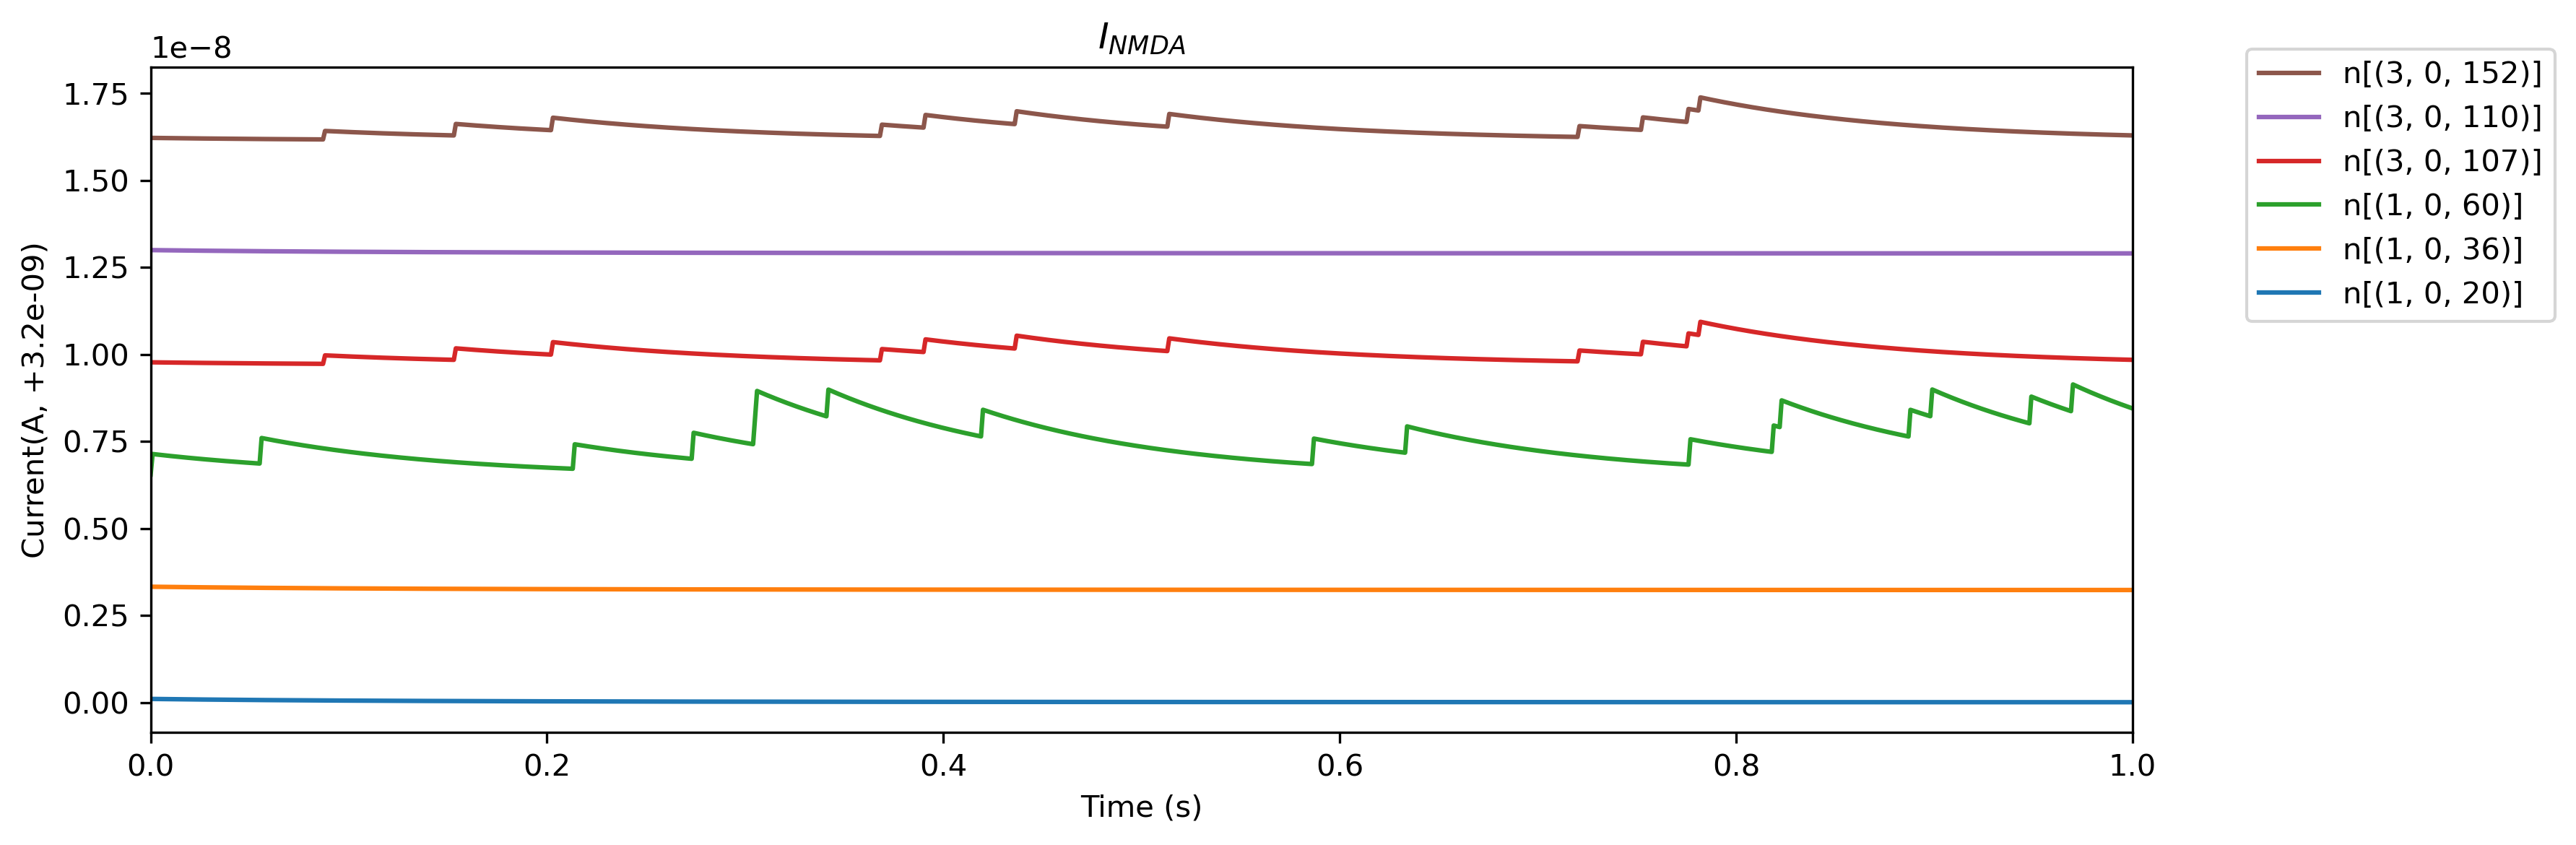

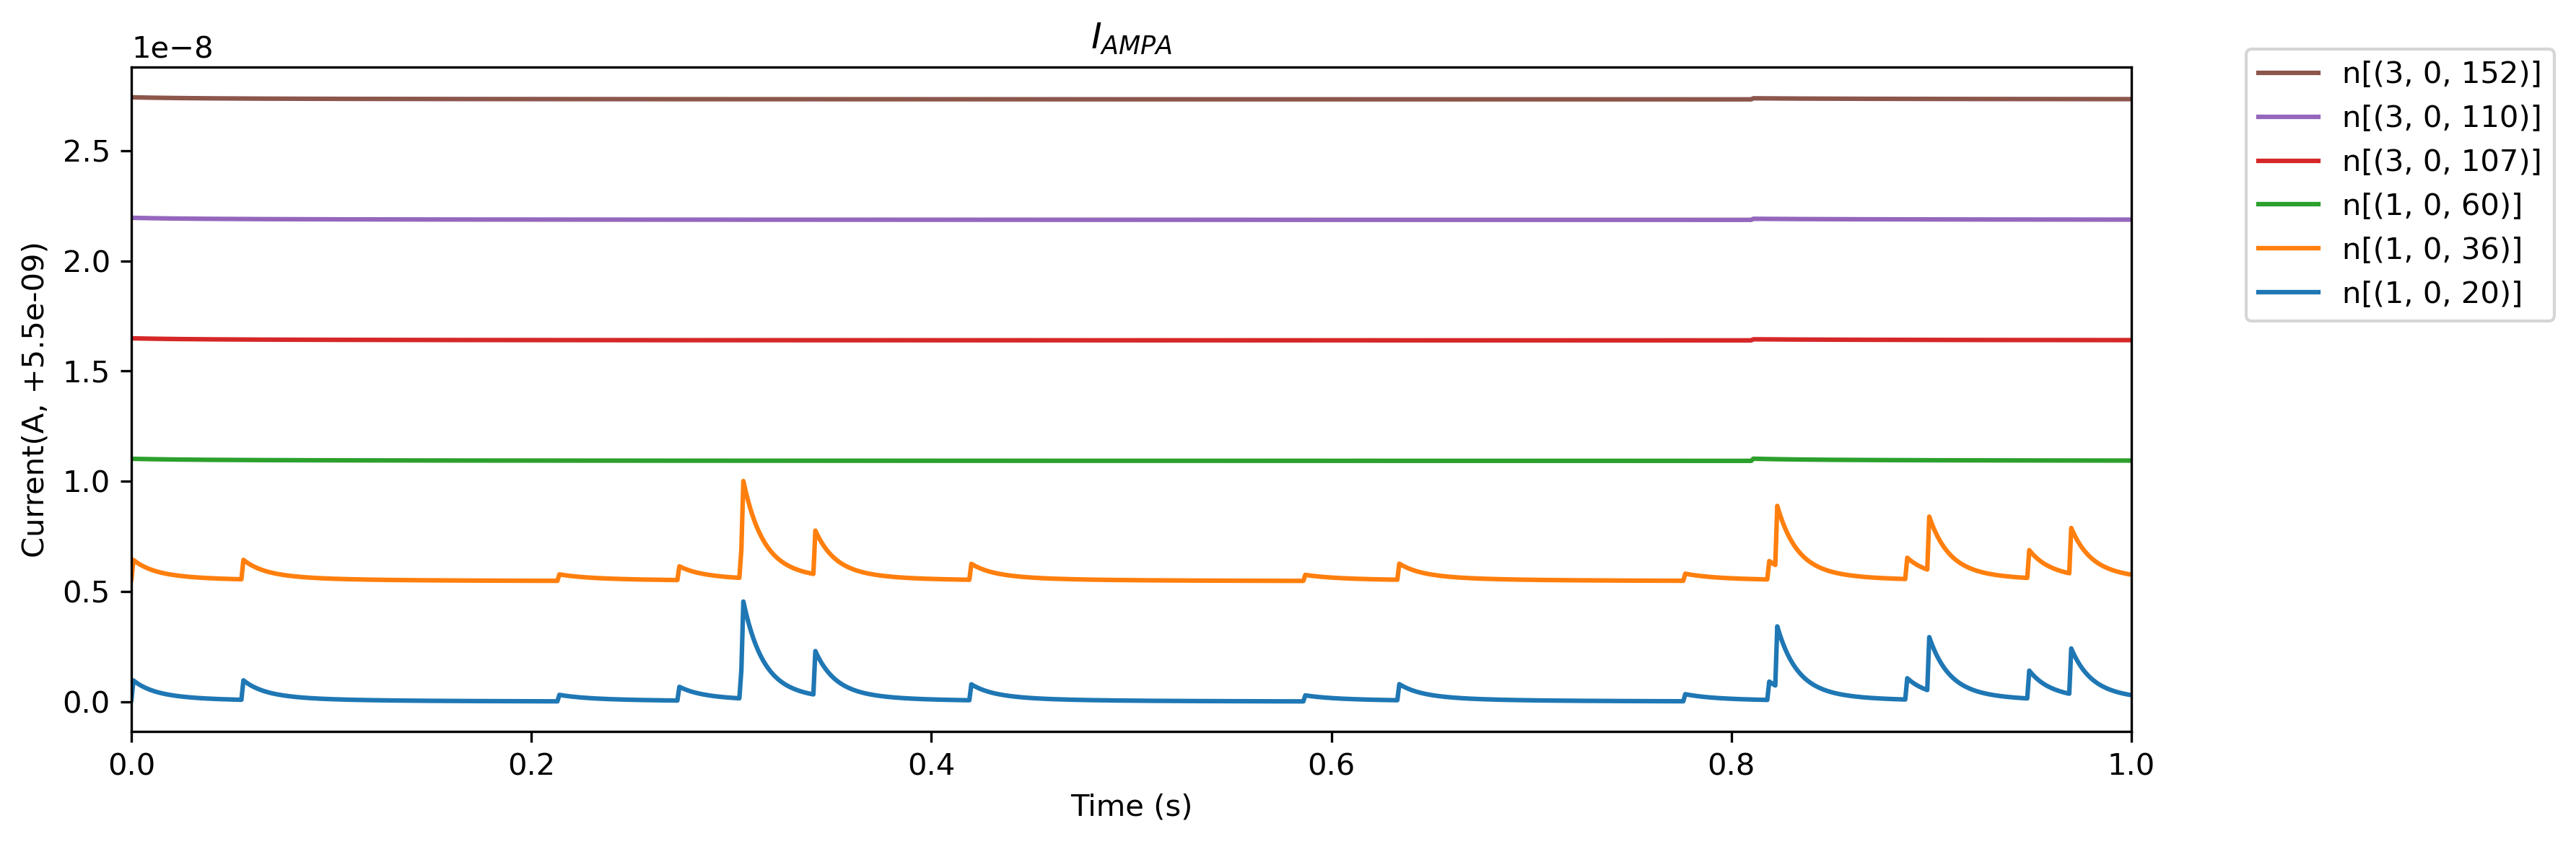

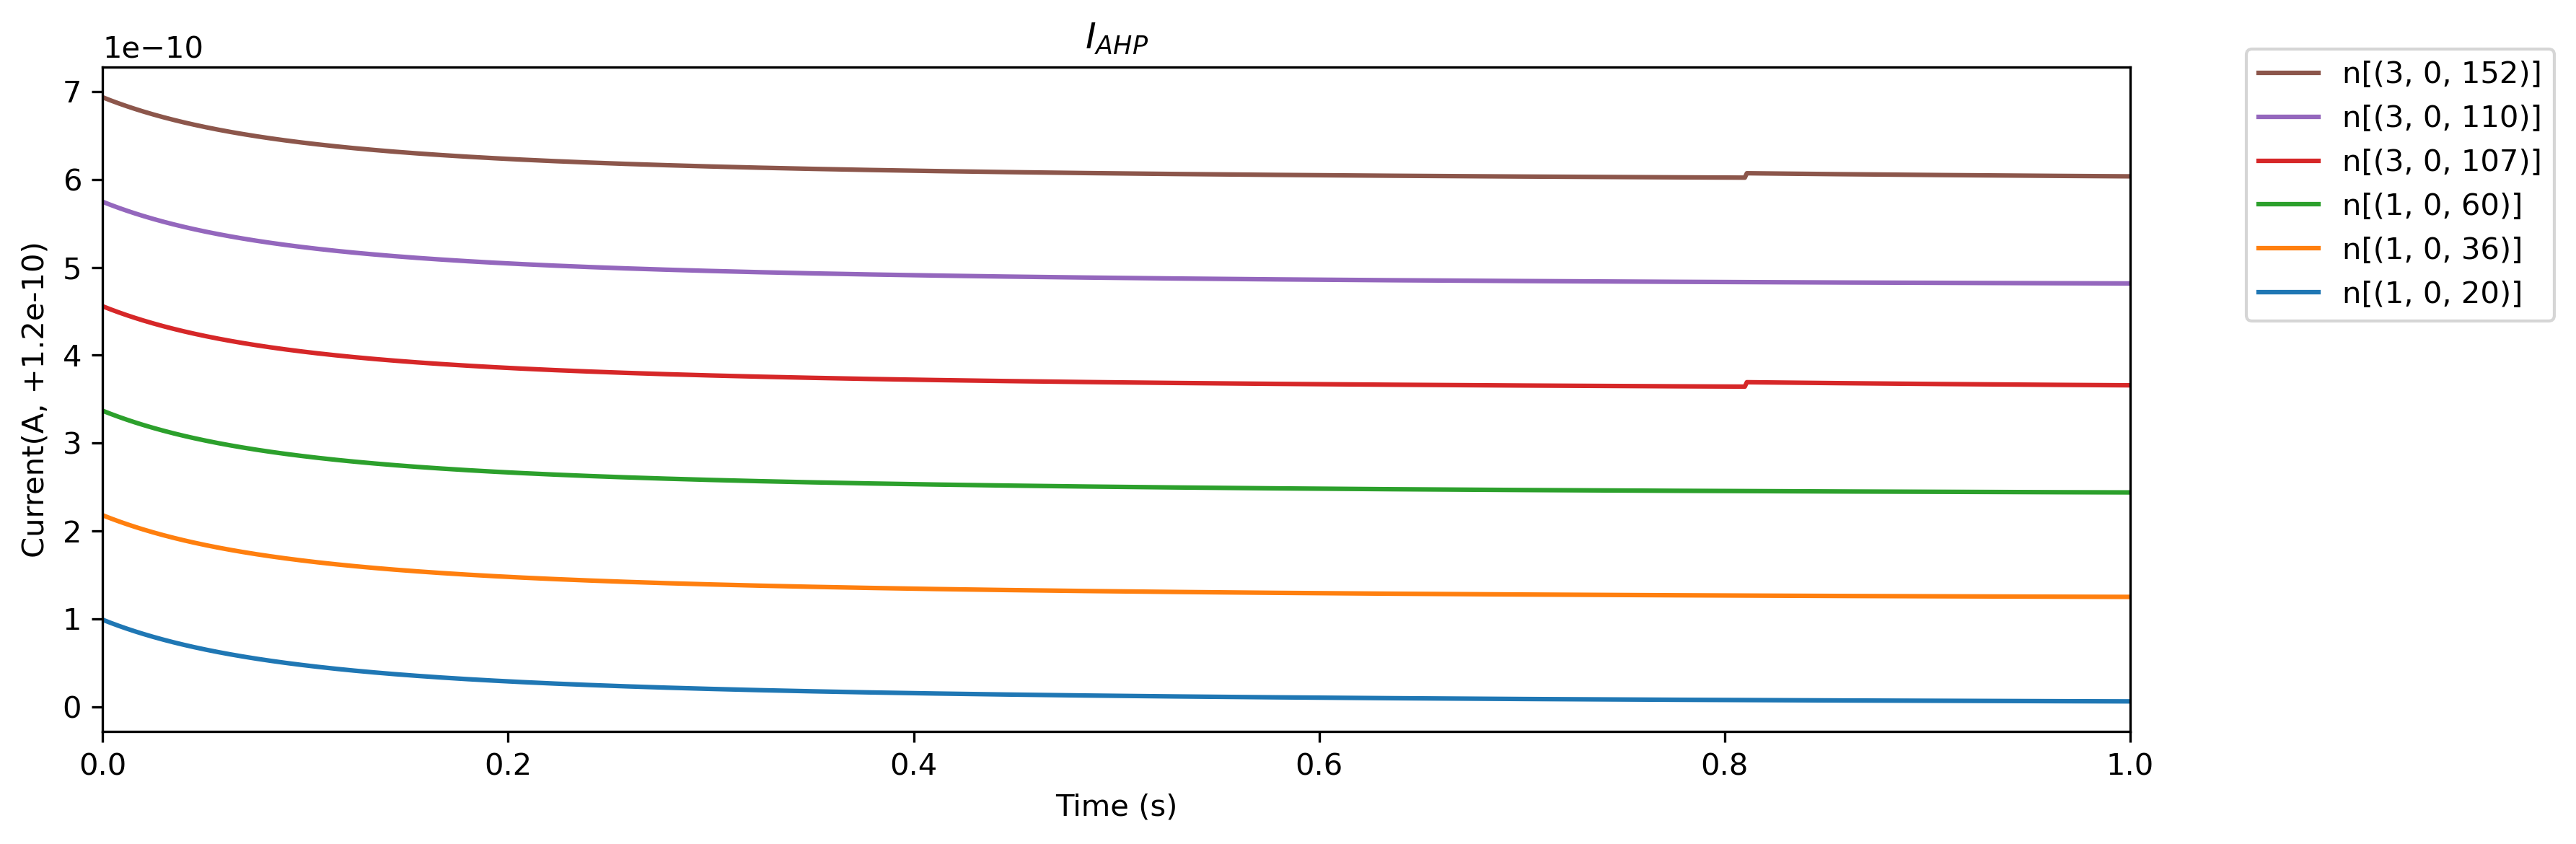

In [35]:
for c in se1.syn_types:
    plt.figure()
    Figure.plot_Ix(rd[f"I{c.lower()}"], name=f"$I_{{{c}}}$", idx_map=se1.idx_map);

In [36]:
se1.idx_map

{0: (1, 0, 20),
 1: (1, 0, 36),
 2: (1, 0, 60),
 3: (3, 0, 107),
 4: (3, 0, 110),
 5: (3, 0, 152)}

In [37]:
fpga.idx_map

{0: (0, 0, 50), 1: (0, 0, 59), 2: (0, 0, 78)}

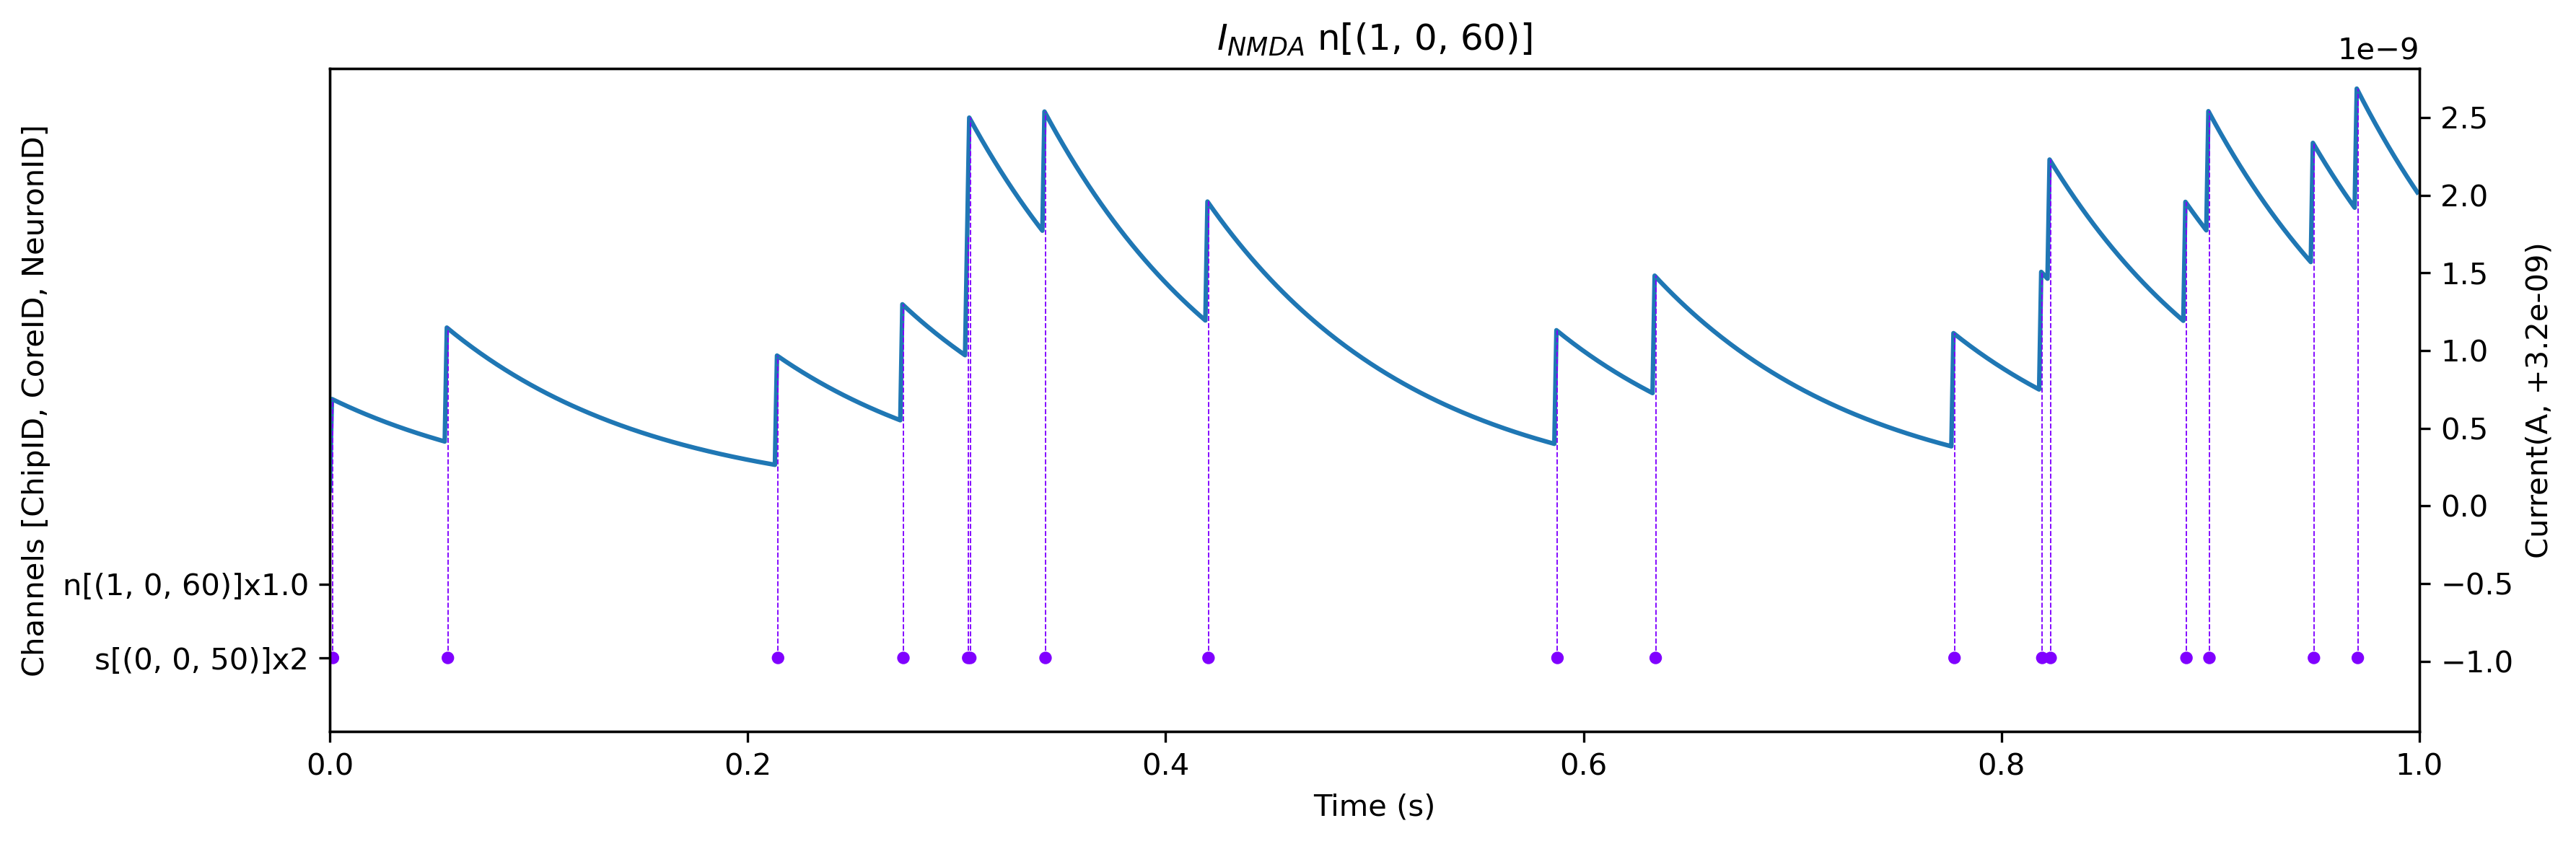

In [38]:
Figure.plot_Isyn_trace(se1, input_ts, out_spikes, rd, (1, 0, 60), "nmda", fpga);

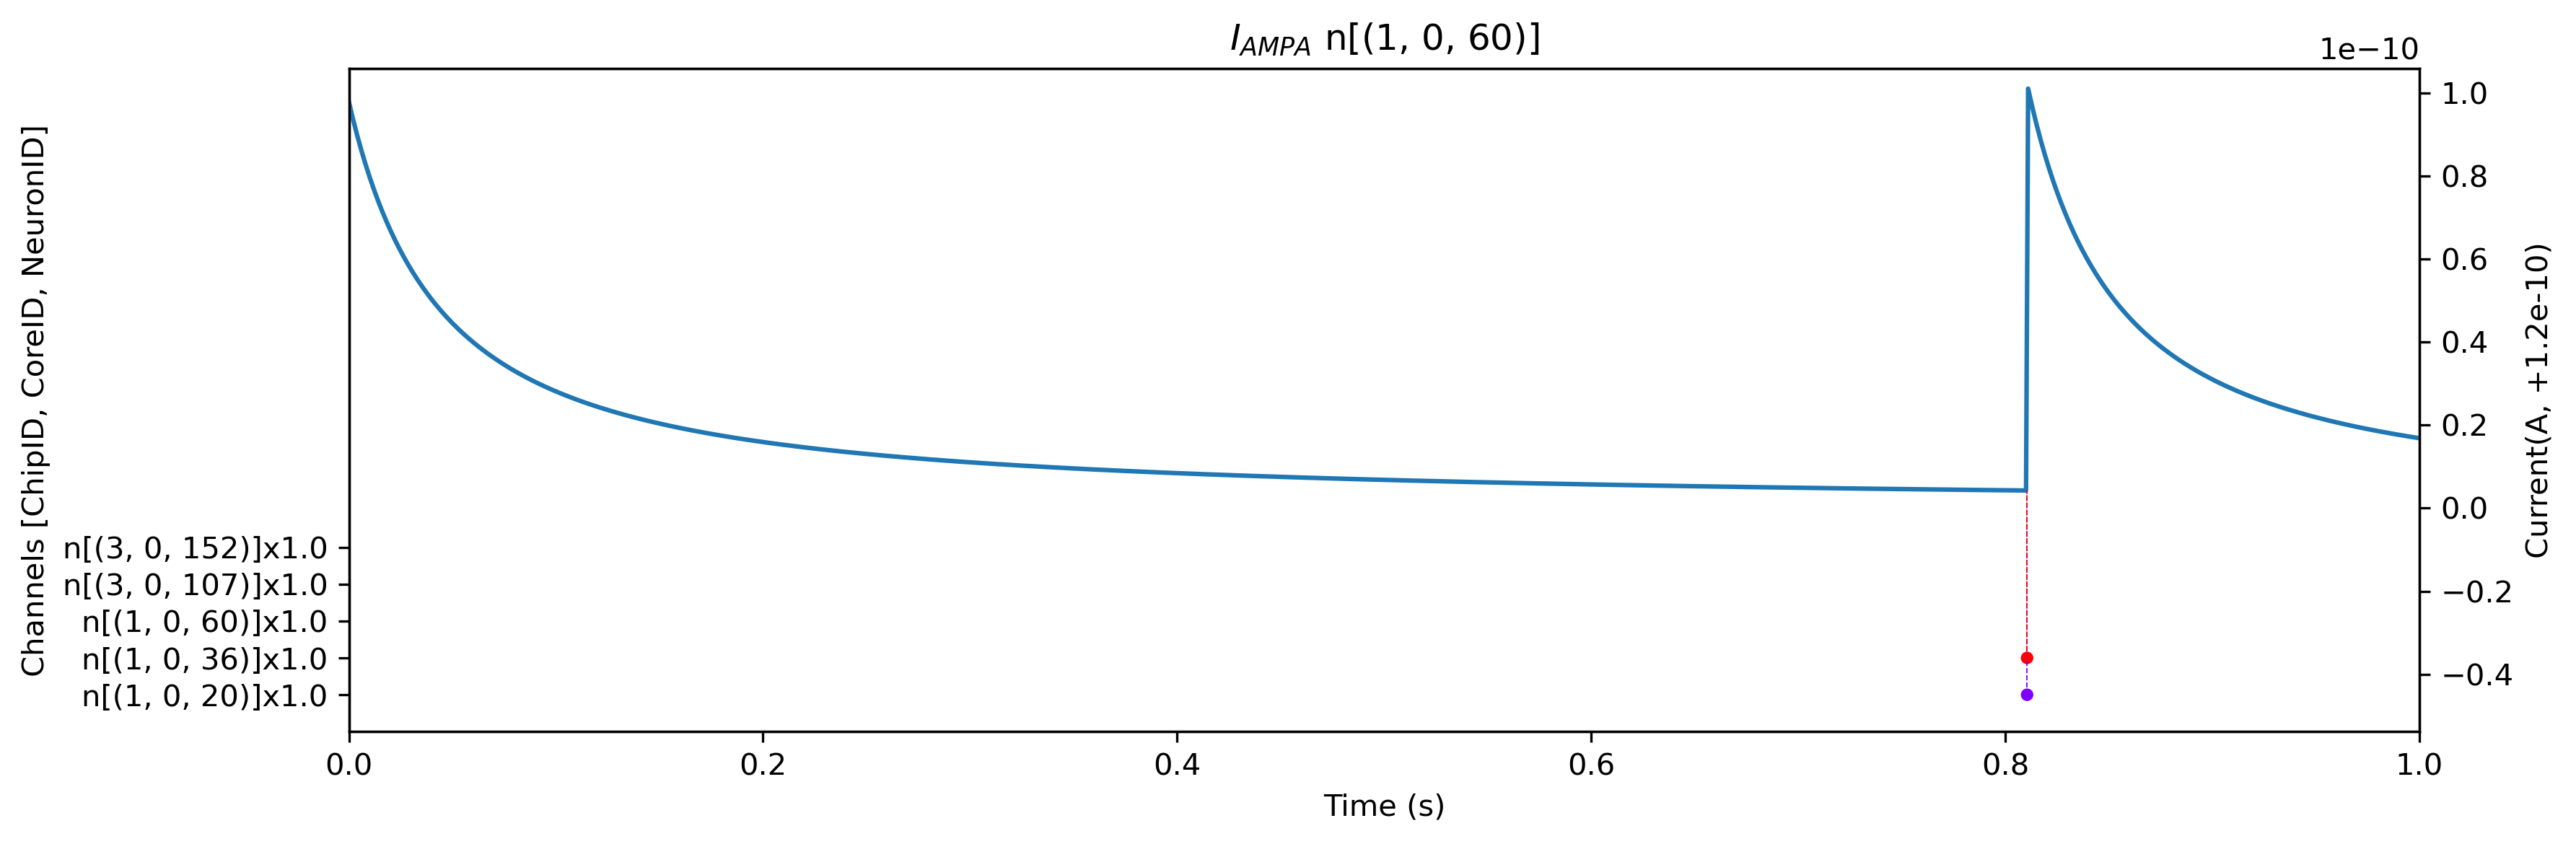

In [39]:
Figure.plot_Isyn_trace(se1, input_ts, out_spikes, rd, (1, 0, 60), "ampa", fpga);

## Deployment Help

In [40]:
se1.core_dict

{(1, 0): {0: 20, 1: 36, 2: 60}, (3, 0): {3: 107, 4: 110, 5: 152}}

In [41]:
print(se1.samna_param_group(1,0).to_json())

{
    "value0": {
        "paramMap": [
            {
                "key": "IF_AHTAU_N",
                "value": {
                    "paramName": "IF_AHTAU_N",
                    "coarseValue": 1,
                    "fineValue": 69,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHTHR_N",
                "value": {
                    "paramName": "IF_AHTHR_N",
                    "coarseValue": 2,
                    "fineValue": 35,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHW_P",
                "value": {
                    "paramName": "IF_AHW_P",
                    "coarseValue": 0,
                    "fineValue": 0,
                    "type": "P"
                }
            },
            {
                "key": "IF_BUF_P",
                "value": {
                    "paramName": "IF_BUF_P",
                    "coarseValue": 4,
           

In [42]:
print(se1.samna_param_group(3,0).to_json())

{
    "value0": {
        "paramMap": [
            {
                "key": "IF_AHTAU_N",
                "value": {
                    "paramName": "IF_AHTAU_N",
                    "coarseValue": 1,
                    "fineValue": 69,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHTHR_N",
                "value": {
                    "paramName": "IF_AHTHR_N",
                    "coarseValue": 2,
                    "fineValue": 35,
                    "type": "N"
                }
            },
            {
                "key": "IF_AHW_P",
                "value": {
                    "paramName": "IF_AHW_P",
                    "coarseValue": 6,
                    "fineValue": 80,
                    "type": "P"
                }
            },
            {
                "key": "IF_BUF_P",
                "value": {
                    "paramName": "IF_BUF_P",
                    "coarseValue": 4,
          